# 0. Import Libraries

In [2]:
#import libraries
import numpy as np
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import Grouper
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import joblib
from joblib import Memory
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV,  ElasticNet, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
# from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.colors import ListedColormap
# import advertools as adv
# import tqdm
# from tqdm import tqdm_notebook
import sklearn
import spacy
from collections import defaultdict
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.corpus.reader.wordnet import NOUN
# from nltk.corpus import wordnet
# from wordcloud import WordCloud
import string
from scipy import stats
import scikitplot as skplt
import scikitplot as skpltimport
from matplotlib.colors import ListedColormap

plt.style.use('fivethirtyeight')

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

# 5. Modelling

## 5.1 Predicting if the stock price goes up or down
The features extracted from the Twitter data frame were resampled by day and used to predict the target. The target was a binary variable calculated based on the 'close' and 'open' stock price feature. When 'open' was higher than 'close', the variable would take a value of '0' and '1' vice versa.

# 5.1.1 Setting the variables

#### Setting Target Predictors

In [2]:
#upload the new csv file
df3 = pd.read_csv('/Users/anasfmatias/Documents/github/Capstone_Project/df3_part1.csv')
df3.head(2)

,Unnamed: 0,verified_status,reply_count,like_count,quote_count,number_followers,text_len,objectivity_avg,polarity_avg,vader_compound,...,order,amc,number_tweets,Open,High,Low,Close,Adj Close,Volume,up_down
0,2020-09-01,-0.115692,-0.007295,-0.005229,-0.011254,-0.042038,0.070693,0.031471,-0.021941,-0.021833,...,0.176952,-0.211828,-0.270104,-0.640851,-0.633120,-0.650223,-0.642535,-0.642535,-0.050901,0
1,2020-09-02,-0.071960,-0.014815,-0.009178,-0.012621,-0.032730,0.134311,-0.015458,0.078108,0.058231,...,0.152979,-0.189698,-0.279451,-0.637965,-0.631124,-0.647174,-0.640516,-0.640516,-0.289669,0


In [3]:
#transform datetime column in a datetime object
df3['Unnamed: 0'] = pd.to_datetime(df3['Unnamed: 0'])

#transform date column in index column
df3.set_index('Unnamed: 0', inplace = True, drop = True)

# #reset index column name
df3.index.name = None
df3.head(2)

,verified_status,reply_count,like_count,quote_count,number_followers,text_len,objectivity_avg,polarity_avg,vader_compound,vader_neg,...,order,amc,number_tweets,Open,High,Low,Close,Adj Close,Volume,up_down
2020-09-01,-0.115692,-0.007295,-0.005229,-0.011254,-0.042038,0.070693,0.031471,-0.021941,-0.021833,-0.000662,...,0.176952,-0.211828,-0.270104,-0.640851,-0.633120,-0.650223,-0.642535,-0.642535,-0.050901,0
2020-09-02,-0.071960,-0.014815,-0.009178,-0.012621,-0.032730,0.134311,-0.015458,0.078108,0.058231,0.013687,...,0.152979,-0.189698,-0.279451,-0.637965,-0.631124,-0.647174,-0.640516,-0.640516,-0.289669,0


In [4]:
#target
y = df3['up_down']

#predictors
X = df3[['verified_status', 'reply_count', 'like_count', 'quote_count',
       'number_followers', 'text_len', 'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos', 'stock', 'buy', 'short', 'market', 'gme', 'trade', 'share',
            'reddit', 'order', 'amc']]


In [5]:
#check the baseline prediction
y.value_counts(normalize=True) 


0    0.70283
1    0.29717
Name: up_down, dtype: float64

#### Train Test Split
Technique for evaluating the performance of a machine learning algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is used to check the performance of the model on new data, data not used on the training model. Because we are dealing with a classification problem is required the stratification of the y argument. This way we ensure that both the train and the test sets have the same proportion of examples in each class.
The size of the test datasets usually depends of the percentage of value per label. In this case we have 70% of False and 30% of True, we will use a split percentage of 67% train and 33% test, the most common proportion close to out values. 

In [6]:
#split the data into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y, test_size=0.33, random_state=1)


#### Standardization
Scale predictor variables to handle any disparities present in the units and precent steps on different axis from varying widely. Standardisation allows direct comparison of the magnitude of impact between different predictors as beta coefficients have similar magnitudes. The fit and transform is carried out on the training set, whereas only the transform is applied to the test set.

In [7]:
#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### 5.1.2. Logistic Regression (Fit and Score Model)

#### Logistic Regression
Logistic regression is a classification algorith, most commonly used when the data in question has a binary output.

In [8]:
#Fit a normal logistic regression model
model_lr = LogisticRegression(penalty='none', max_iter = 2000)
model_lr.fit(X_train, y_train)
joblib.dump(model_lr, 'model_lr.jlib')

['model_lr.jlib']

In [9]:
#model_lr = joblib.load('model_lr.jlib')
scores = cross_val_score(model_lr, X_train, y_train, cv=5)

#summarize the results
print('Cross Validation Scores:', scores)
print('Mean Cross Validation Scores: {:.2f}'.format(np.mean(scores)))
print('Accuracy of Logistic Regression Classifier on Training Set: {:.2f}'.format(model_lr.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on Test Set: {:.2f}'.format(model_lr.score(X_test, y_test)))


Cross Validation Scores: [0.79310345 0.62068966 0.71428571 0.60714286 0.67857143]
Mean Cross Validation Scores: 0.68
Accuracy of Logistic Regression Classifier on Training Set: 0.82
Accuracy of Logistic Regression Classifier on Test Set: 0.70


In [10]:
# Create a dataframe to look at the coefficients
coef_df_lr = pd.DataFrame({'feature': X.columns,
                        'coef': model_lr.coef_[0],
                        'abs_coef': np.abs(model_lr.coef_[0])})

In [11]:
# Sort by absolute value of coefficient (magnitude)
coef_df_lr = coef_df_lr.sort_values(by='abs_coef', ascending=False)
coef_df_lr

,feature,coef,abs_coef
6,vader_compound,3.126834,3.126834
9,vader_pos,-1.776578,1.776578
7,vader_neg,1.214817,1.214817
18,order,-1.107953,1.107953
10,stock,1.034872,1.034872
5,text_len,-0.783073,0.783073
4,number_followers,0.767049,0.767049
16,share,-0.762591,0.762591
17,reddit,-0.592845,0.592845
12,short,0.550252,0.550252


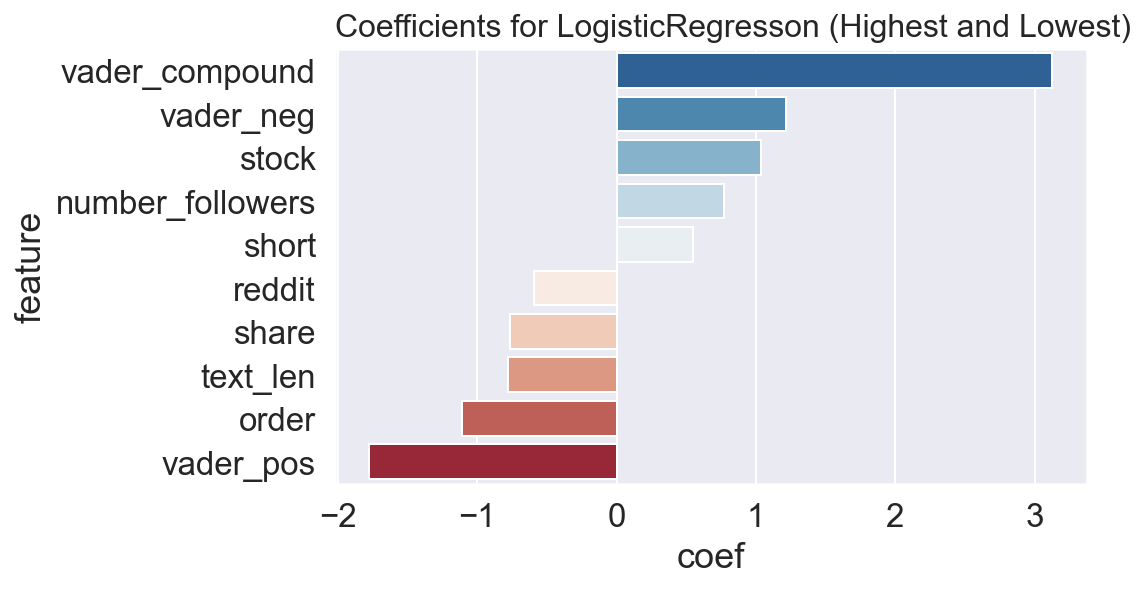

In [12]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_lr.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Logistic Regression under Ridge Regularization

In [13]:
#train the model under ridge regularization
lr_ridge = LogisticRegressionCV(Cs=np.logspace(-4,4,15), 
                                penalty='l2', cv=5, max_iter=2000, n_jobs = -1)

lr_ridge.fit(X_train, y_train)
lr_ridge_best = LogisticRegression(penalty='l2', C=lr_ridge.C_[0])
lr_ridge_best.fit(X_train, y_train)
joblib.dump(lr_ridge_best, 'lr_ridge_best.jlib')

['lr_ridge_best.jlib']

In [14]:
#lr_ridge_best = joblib.load('lr_ridge_best.jlib')
cross_val = cross_val_score(lr_ridge_best, X_train, y_train, cv=5).mean()

#summarize results
print('Best Alpha(Ridge): {:.2f}'.format(lr_ridge.C_[0]))
print('Cross Validation Score(Ridge): {:.2f}'.format(cross_val))
print('Accuracy of Logistic Regression Classifier on Training Set(Ridge): {:.2f}'.format(lr_ridge_best.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on Test Set(Ridge): {:.2f}'.format(lr_ridge_best.score(X_test, y_test)))


Best Alpha(Ridge): 3.73
Cross Validation Score(Ridge): 0.73
Accuracy of Logistic Regression Classifier on Training Set(Ridge): 0.82
Accuracy of Logistic Regression Classifier on Test Set(Ridge): 0.70


In [15]:
# Create a dataframe to look at the coefficients
coef_df_lr_ridge  = pd.DataFrame({'feature': X.columns,
                        'coef': lr_ridge_best.coef_[0],
                        'abs_coef': np.abs(lr_ridge_best.coef_[0])})
# Sort by absolute value of coefficient (magnitude)
coef_df_lr_ridge = coef_df_lr_ridge.sort_values(by='abs_coef', ascending=False)
coef_df_lr_ridge

,feature,coef,abs_coef
6,vader_compound,2.107781,2.107781
9,vader_pos,-1.126690,1.126690
18,order,-1.072348,1.072348
10,stock,0.810172,0.810172
16,share,-0.680512,0.680512
5,text_len,-0.667204,0.667204
7,vader_neg,0.611655,0.611655
4,number_followers,0.591109,0.591109
17,reddit,-0.542926,0.542926
12,short,0.464380,0.464380


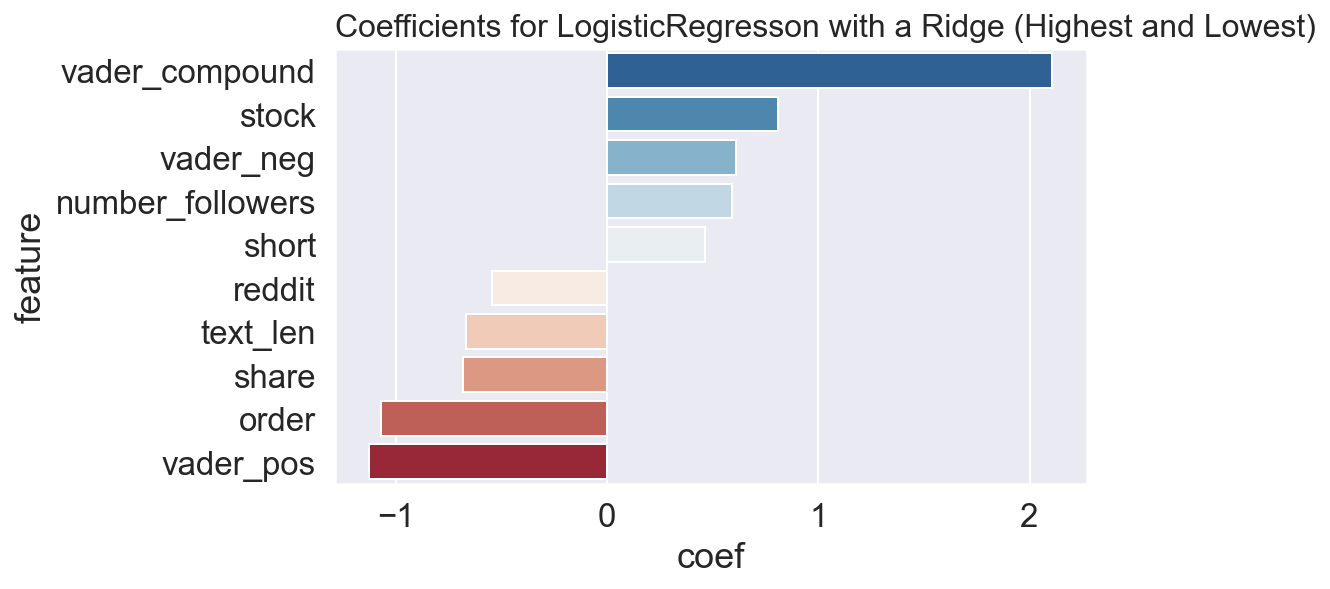

In [16]:
# Plot the coefficient table
sort_coef_lr_ridge = pd.concat([coef_df_lr_ridge.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr_ridge.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef_lr_ridge.feature, x = sort_coef_lr_ridge.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson with a Ridge (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Logistic Regression under Lasso Regularization

In [17]:
#train the model under lasso regularization
lr_lasso = LogisticRegressionCV(Cs=np.logspace(-4,4,15), penalty='l1', 
                                 cv=5, solver='liblinear', max_iter=5000, n_jobs = -1)

lr_lasso.fit(X_train, y_train)
lr_lasso_best = LogisticRegression(penalty='l2', C=lr_lasso.C_[0])
lr_lasso_best.fit(X_train, y_train)
joblib.dump(lr_lasso_best, 'lr_lasso_best.jlib')

['lr_lasso_best.jlib']

In [18]:
#lr_lasso_best = joblib.load('lr_lasso_best.jlib')
cross_val = cross_val_score(lr_lasso_best, X_train, y_train, cv=5).mean()

#summarize results
print('Best Alpha(Lasso):', lr_lasso.C_[0])
print('Cross Validation Score(Lasso): {:.2f}'.format(cross_val))
print('Accuracy of Logistic Regression Classifier on Training Set(Lasso): {:.2f}'.format(lr_lasso_best.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on Test Set(Lasso): {:.2f}'.format(lr_lasso_best.score(X_test, y_test)))

Best Alpha(Lasso): 1.0
Cross Validation Score(Lasso): 0.73
Accuracy of Logistic Regression Classifier on Training Set(Lasso): 0.80
Accuracy of Logistic Regression Classifier on Test Set(Lasso): 0.73


In [19]:
# Create a DataFrame to look at the coefficients
coef_df_lr_lasso = pd.DataFrame({'feature': X.columns,
                        'coef': lr_lasso_best.coef_[0],
                        'abs_coef': np.abs(lr_lasso_best.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_lr_lasso = coef_df_lr_lasso.sort_values(by='abs_coef', ascending=False)
coef_df_lr_lasso

,feature,coef,abs_coef
6,vader_compound,1.272223,1.272223
18,order,-0.954338,0.954338
9,vader_pos,-0.590705,0.590705
10,stock,0.569426,0.569426
5,text_len,-0.556505,0.556505
16,share,-0.539973,0.539973
17,reddit,-0.449153,0.449153
4,number_followers,0.408777,0.408777
12,short,0.355417,0.355417
0,verified_status,-0.318190,0.318190


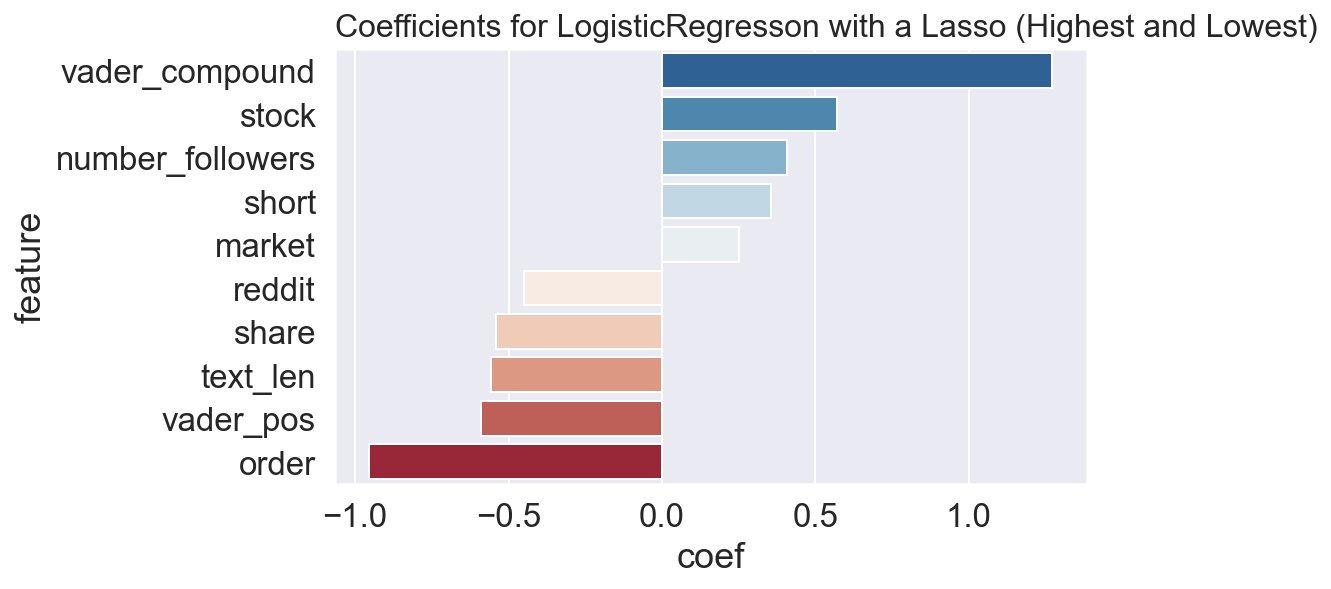

In [20]:
# Plot the coefficient table
sort_coef_lr_lasso = pd.concat([coef_df_lr_lasso.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr_lasso.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef_lr_lasso.feature, x = sort_coef_lr_lasso.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson with a Lasso (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Logistic Regression with ElasticNet

In [21]:
#train the model under elasticnet regularization
lr_el = LogisticRegressionCV(Cs = np.logspace(-4,4,15), 
                                      penalty='elasticnet', cv=5, solver='saga', 
                                      l1_ratios = [0.001, 0.1, 0.05, 0.1, 0.5], n_jobs=-1, max_iter = 20000, tol = 0.01)

lr_el.fit(X_train, y_train)
lr_el_best = LogisticRegression(penalty='elasticnet', C=lr_el.C_[0], l1_ratio=lr_el.l1_ratio_[0], solver='saga', max_iter = 20000)
lr_el_best.fit(X_train, y_train)
joblib.dump(lr_el_best, 'lr_el_best.jlib')

['lr_el_best.jlib']

In [22]:
#lr_el_best = joblib.load('lr_el_best.jlib')
cross_val = cross_val_score(lr_el_best, X_train, y_train, cv=5).mean()

#summarize results
print('Best Alpha(ElasticNet):', lr_el.C_[0])
print('Cross Validation Score(ElasticNet): {:.2f}'.format(cross_val))
print('Accuracy of Logistic Regression Classifier on Training Set(ElasticNet): {:.2f}'.format(lr_el_best.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on Test Set(ElasticNet): {:.2f}'.format(lr_el_best.score(X_test, y_test)))


Best Alpha(ElasticNet): 10000.0
Cross Validation Score(ElasticNet): 0.70
Accuracy of Logistic Regression Classifier on Training Set(ElasticNet): 0.82
Accuracy of Logistic Regression Classifier on Test Set(ElasticNet): 0.70


In [23]:
# Create a DataFrame to look at the coefficients
coef_df_lr_elast = pd.DataFrame({'feature': X.columns,
                        'coef': lr_el_best.coef_[0],
                        'abs_coef': np.abs(lr_el_best.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_lr_elast = coef_df_lr_elast.sort_values(by='abs_coef', ascending=False)
coef_df_lr_elast

,feature,coef,abs_coef
6,vader_compound,3.078509,3.078509
9,vader_pos,-1.746272,1.746272
7,vader_neg,1.183970,1.183970
18,order,-1.109768,1.109768
10,stock,1.032326,1.032326
5,text_len,-0.778240,0.778240
16,share,-0.762475,0.762475
4,number_followers,0.761717,0.761717
17,reddit,-0.593234,0.593234
12,short,0.546778,0.546778


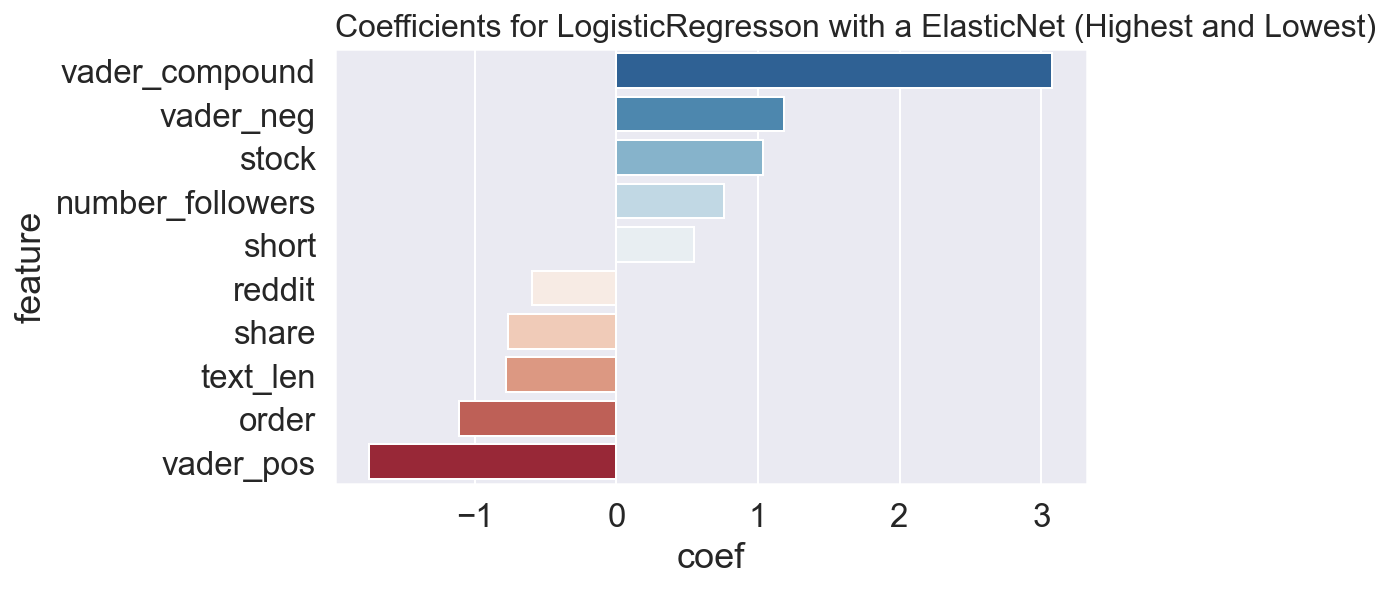

In [24]:
# Plot the coefficient table
sort_coef_lr_elast = pd.concat([coef_df_lr_elast.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr_elast.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef_lr_elast.feature, x = sort_coef_lr_elast.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson with a ElasticNet (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Fit a GridSearch CV to get the Best Parameters

In [25]:
# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search_lib = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
search_lib.fit(X_train, y_train)
joblib.dump(search_lib, 'search_lib.jlib')

['search_lib.jlib']

In [26]:
#search_saga = joblib.load('search_saga.jlib')
cross_val = cross_val_score(search_lib, X_train, y_train, cv=5).mean()

# summarize result
print('Best Score: %s' % search_lib.best_score_)
print('Best Hyperparameters: %s' % search_lib.best_params_)
print('Cross Validation Score(Logistic Regression):', cross_val)
print('Accuracy of Random Forest Classifier on Training Set(Logistic Regression): {:.2f}'.format(search_lib.score(X_train, y_train)))
print('Accuracy of Random Forest Classifier on Test Set(Logistic Regression): {:.2f}'.format(search_lib.score(X_test, y_test)))

Best Score: 0.7926984126984127
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Cross Validation Score(Logistic Regression): 0.7879310344827586
Accuracy of Random Forest Classifier on Training Set(Logistic Regression): 0.80
Accuracy of Random Forest Classifier on Test Set(Logistic Regression): 0.77


In [27]:
# Create a DataFrame to look at the coefficients
coef_df_log_reg = pd.DataFrame({'feature': X.columns,
                        'coef': search_lib.best_estimator_.coef_[0],
                        'abs_coef': np.abs(search_lib.best_estimator_.coef_[0])})

# Sort by absolute value of coefficient (magnitude)
coef_df_log_reg = coef_df_log_reg.sort_values(by='abs_coef', ascending=False)
coef_df_log_reg

,feature,coef,abs_coef
18,order,-0.105656,0.105656
14,gme,0.098501,0.098501
6,vader_compound,0.087865,0.087865
5,text_len,-0.086972,0.086972
10,stock,0.078141,0.078141
13,market,0.069326,0.069326
7,vader_neg,-0.064805,0.064805
19,amc,0.063903,0.063903
12,short,0.059331,0.059331
4,number_followers,0.056589,0.056589


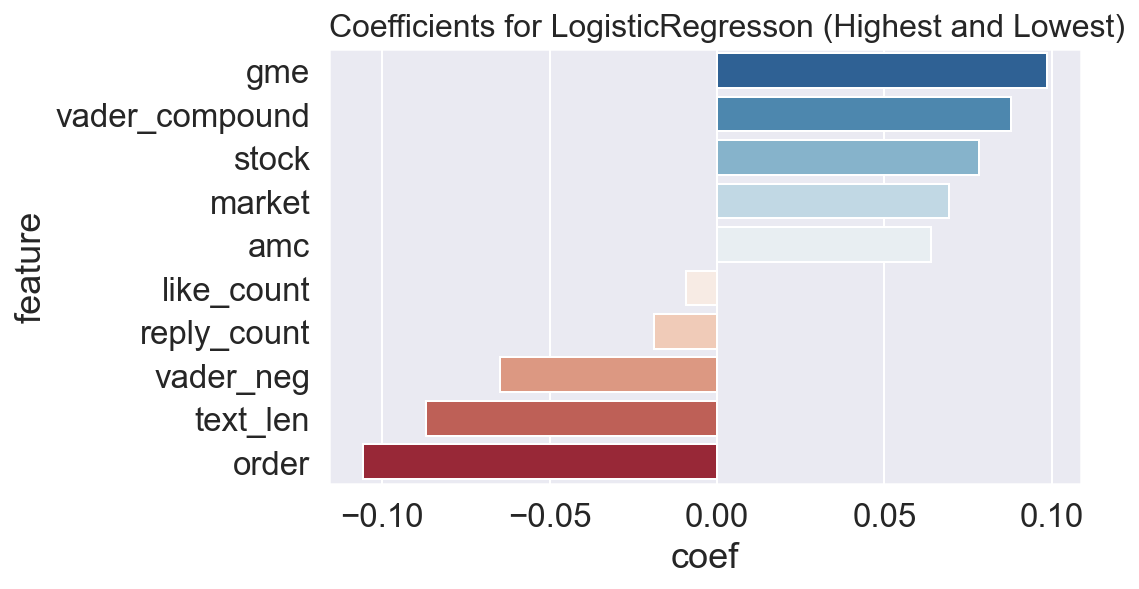

In [28]:
# Plot the coefficient table
coef_df_log_reg = pd.concat([coef_df_log_reg.sort_values(by='coef', ascending=False).head(5),
                      coef_df_log_reg.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = coef_df_log_reg.feature, x = coef_df_log_reg.coef, palette = "RdBu_r")
plt.title("Coefficients for LogisticRegresson (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

In [29]:
# Note that those algorithms may not work with specific penalty.
#          Supported penalties by solver:
#          - 'newton-cg'   -   ['l2', 'none']
#          - 'lbfgs'       -   ['l2', 'none']
#          - 'liblinear'   -   ['l1', 'l2']
#          - 'sag'         -   ['l2', 'none']
#          - 'saga'        -   ['elasticnet', 'l1', 'l2', 'none']

### 5.1.3. Random Forest (Fit and Score Model)
Random forest is an emsemble machine learning algorithm, that consist on an ensemble of decision trees. Randomness is used 

In [30]:
#train the model under Random Forest
rand_model = RandomForestClassifier(
                            max_depth=3, 
                            n_estimators=100,
                            random_state=1)
rand_model.fit(X_train, y_train)
joblib.dump(rand_model, 'rand_model.jlib')

['rand_model.jlib']

In [31]:
#rand_model = joblib.load('rand_model.jlib')
coss_val = cross_val_score(rand_model, X_train, y_train, cv=5).mean()

#summarize results
print('Cross Validation Score(Random Forest):', cross_val)
print('Accuracy of Random Forest Classifier on Training Set(Random Forest): {:.2f}'.format(rand_model.score(X_train, y_train)))
print('Accuracy of Random Forest Classifier on Test Set(Random Forest): {:.2f}'.format(rand_model.score(X_test, y_test)))

Cross Validation Score(Random Forest): 0.7879310344827586
Accuracy of Random Forest Classifier on Training Set(Random Forest): 0.89
Accuracy of Random Forest Classifier on Test Set(Random Forest): 0.77


In [32]:
# Create a DataFrame to look at the coefficients
coef_df_rand_mod = pd.DataFrame({'feature': X.columns,
                        'coef': rand_model.feature_importances_,
                        'abs_coef': np.abs(rand_model.feature_importances_)})

# Sort by absolute value of coefficient (magnitude)
coef_df_rand_mod = coef_df_rand_mod.sort_values(by='abs_coef', ascending=False)
coef_df_rand_mod

,feature,coef,abs_coef
10,stock,0.157675,0.157675
12,short,0.151722,0.151722
18,order,0.108781,0.108781
16,share,0.089123,0.089123
13,market,0.075951,0.075951
15,trade,0.065312,0.065312
14,gme,0.051086,0.051086
17,reddit,0.043036,0.043036
19,amc,0.035540,0.035540
7,vader_neg,0.029629,0.029629


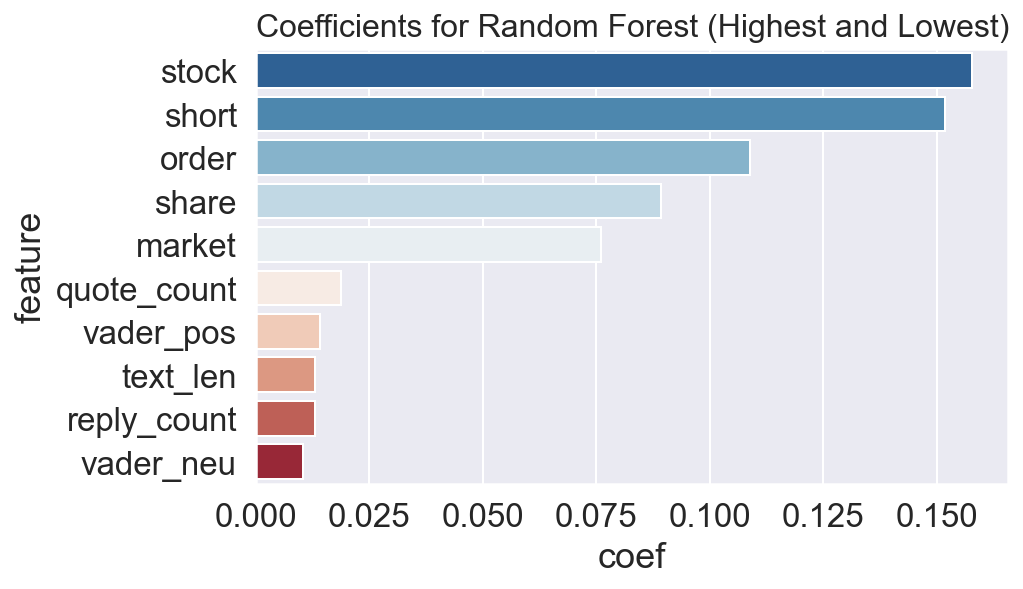

In [33]:
# Plot the coefficient table
coef_df_rand_mod = pd.concat([coef_df_rand_mod.sort_values(by='coef', ascending=False).head(5),
                      coef_df_rand_mod.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = coef_df_rand_mod.feature, x = coef_df_rand_mod.coef, palette = "RdBu_r")
plt.title("Coefficients for Random Forest (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Fit a GridSearch CV to get the Best Parameters

In [34]:
from sklearn.model_selection import RandomizedSearchCV
#train the model under Random Fores
rf = RandomForestClassifier(n_estimators=100)

#Set parameters for the GridSearch
params = {
    'max_depth': [3, 6, 9, 12, 16, 18, 20],
    'criterion': ['entropy', 'gini'],
    'max_features': np.linspace(0.1,1.0, 20),
}

#Set a GridSearch and fit the model
gs_rf = GridSearchCV(rf, params, n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(X_train, y_train)
joblib.dump(gs_rf, 'gs_rf.jlib')

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


['gs_rf.jlib']

In [35]:
#gs_rf = joblib.load('gs_rf.jlib')
cross_val = cross_val_score(gs_rf, X_train, y_train, cv=5).mean()

#summarize results
print('Best Parameters:', gs_rf.best_params_)
print('Cross Validation Score(Random Forest):', cross_val)
print('Accuracy of Random Forest Classifier on Training Set: {:.2f}'.format(gs_rf.score(X_train, y_train)))
print('Accuracy of Random Forest Classifier on Test Set: {:.2f}'.format(gs_rf.score(X_test, y_test)))

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.19473684210526315}
Cross Validation Score(Random Forest): 0.80935960591133
Accuracy of Random Forest Classifier on Training Set: 0.87
Accuracy of Random Forest Classifier on Test Set: 0.79


In [36]:
# Create a DataFrame to look at the coefficients
coef_gs_rand_mod = pd.DataFrame({'feature': X.columns,
                        'coef': gs_rf.best_estimator_.feature_importances_,
                        'abs_coef': np.abs(gs_rf.best_estimator_.feature_importances_)})

# Sort by absolute value of coefficient (magnitude)
coef_gs_rand_mod = coef_gs_rand_mod.sort_values(by='abs_coef', ascending=False)
coef_gs_rand_mod

,feature,coef,abs_coef
10,stock,0.125205,0.125205
18,order,0.116621,0.116621
16,share,0.094555,0.094555
13,market,0.091324,0.091324
12,short,0.072989,0.072989
15,trade,0.058554,0.058554
17,reddit,0.052999,0.052999
14,gme,0.042322,0.042322
19,amc,0.041595,0.041595
4,number_followers,0.037273,0.037273


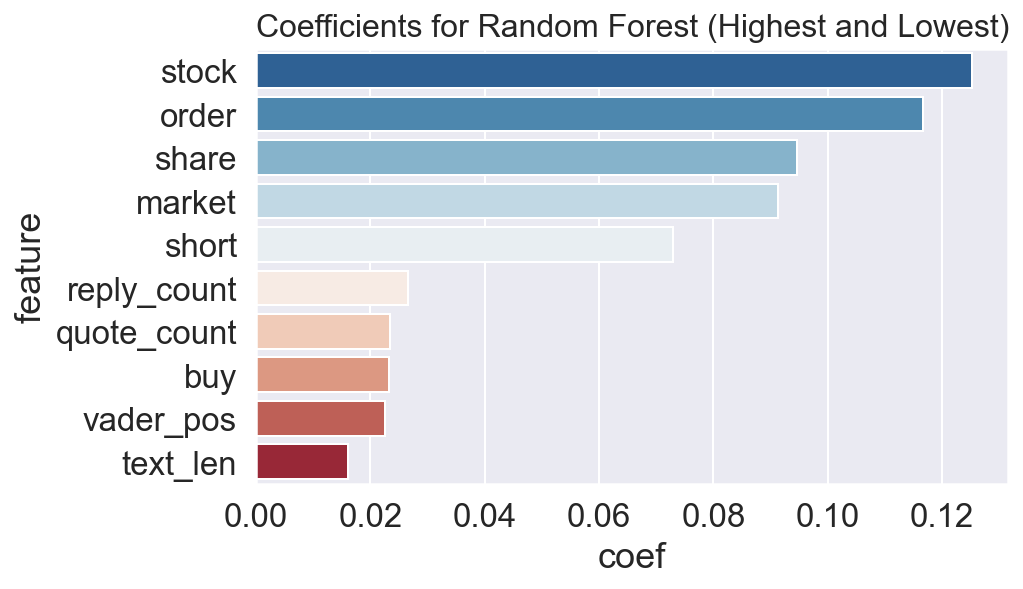

In [37]:
# Plot the coefficient table
coef_gs_rand_mod = pd.concat([coef_gs_rand_mod.sort_values(by='coef', ascending=False).head(5),
                      coef_gs_rand_mod.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = coef_gs_rand_mod.feature, x = coef_gs_rand_mod.coef, palette = "RdBu_r")
plt.title("Coefficients for Random Forest (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

### 5.1.4. KNN Classifier (Fit and Score Model)

In [38]:
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 5]}
gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=5,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True,
                      n_jobs=-1,)
gs_KNN.fit(X_train, y_train)
joblib.dump(gs_KNN, 'gs_KNN.jlib')

Fitting 5 folds for each of 21 candidates, totalling 105 fits


['gs_KNN.jlib']

In [39]:
#gs_KNN = joblib.load('gs_KNN.jlib')
cross_val = cross_val_score(gs_KNN, X_train, y_train, cv=5).mean()

print(f'Best Score:', {gs_KNN.best_score_})
print('Cross Validation Score:', cross_val)
print('Accuracy of K-NN Classifier on Training Set: {:.2f}'.format(gs_KNN.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(gs_KNN.score(X_test, y_test)))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best Score: {0.816256157635468}
Cross Validation Score: 0.802463054187192
Accuracy of K-NN Classifier on Training Set: 0.85
Accuracy of K-NN classifier on test set: 0.79


### 5.1.5. Gaussian Naive Bayes

In [40]:
#train the model under Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
joblib.dump(gnb, 'gnb.jlib')

['gnb.jlib']

In [41]:
#gnb = joblib.load('gnb.jlib')
cross_val = cross_val_score(gnb, X_train, y_train, cv=5).mean()

#summarize results
print('Cross Validation Score:', cross_val_score(gnb, X_train, y_train, cv=5).mean())
print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

Cross Validation Score: 0.7738916256157635
Accuracy of GNB classifier on training set: 0.80
Accuracy of GNB classifier on test set: 0.77


### 5.1.6. Bagging Classifier

In [42]:
# Create our classifier and our bag
DT = DecisionTreeClassifier()
BC = BaggingClassifier(base_estimator=DT,
                       n_estimators=50,
                       #max_features=1,
                       max_samples=0.5,
                       oob_score=True)

BC.fit(X_train, y_train)
joblib.dump(BC, 'BC.jlib')

['BC.jlib']

In [43]:
#BC = joblib.load('BC.jlib')
cross_val = cross_val_score(BC, X_train, y_train, cv=5).mean()

#summarize results
print('Cross Validation Score:', cross_val_score(BC, X_train, y_train, cv=5).mean())
print('Accuracy of GNB classifier on training set: {:.2f}'.format(BC.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'.format(BC.score(X_test, y_test)))

Cross Validation Score: 0.8096059113300493
Accuracy of GNB classifier on training set: 0.96
Accuracy of GNB classifier on test set: 0.81


In [44]:
#select all the coefficients
n_estimators=50
coef_GNB = [sum(val)/(n_estimators-1) for val in zip(*[BC.estimators_[i].feature_importances_ for i in range(n_estimators-1)])]

# Create a DataFrame to look at the coefficients
coef_GNB = pd.DataFrame({'feature': X.columns,
                        'coef': coef_GNB,
                        'abs_coef': np.abs(coef_GNB)})

# Sort by absolute value of coefficient (magnitude)
coef_GNB = coef_GNB.sort_values(by='abs_coef', ascending=False)
coef_GNB

,feature,coef,abs_coef
10,stock,0.225615,0.225615
18,order,0.161677,0.161677
16,share,0.100592,0.100592
13,market,0.058829,0.058829
12,short,0.057794,0.057794
7,vader_neg,0.057630,0.057630
2,like_count,0.039596,0.039596
11,buy,0.037750,0.037750
6,vader_compound,0.034569,0.034569
14,gme,0.032384,0.032384


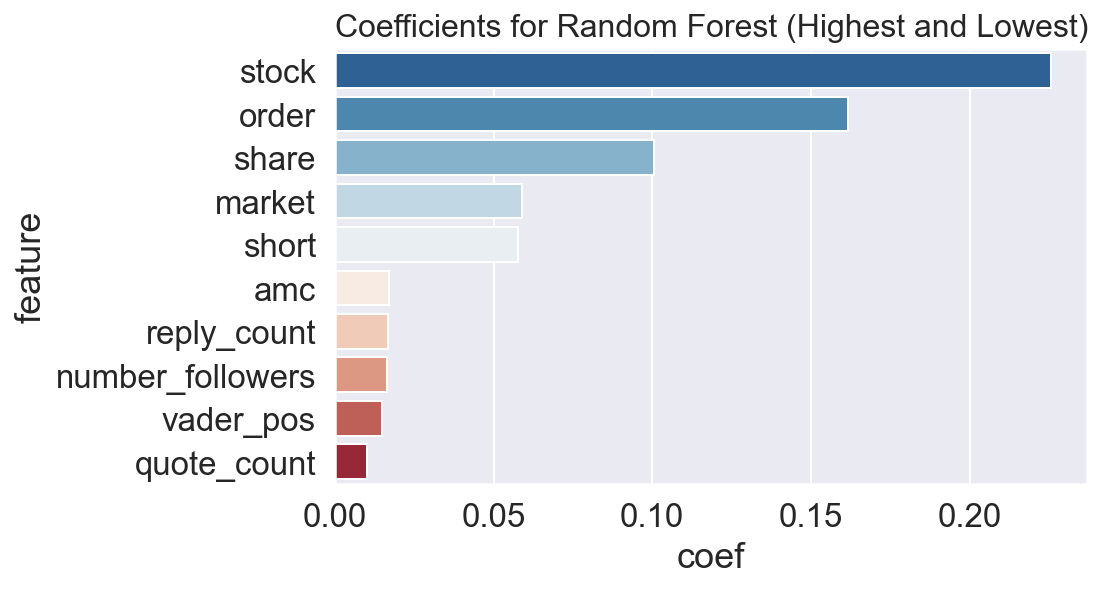

In [45]:
# Plot the coefficient table
coef_GNB = pd.concat([coef_GNB.sort_values(by='coef', ascending=False).head(5),
                      coef_GNB.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = coef_GNB.feature, x = coef_GNB.coef, palette = "RdBu_r")
plt.title("Coefficients for Random Forest (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

### 5.1.7. Evaluation of the Model _ Confusion Matrix

Below is the confusion matrix for train and test data. For train data, the predicted target had an accuracy of 0.702, recall of 0.943 and precision of 0.912. For the test set, the predicted target had an accuracy of 0.76, recall of 0.857 and precision of 0.811.

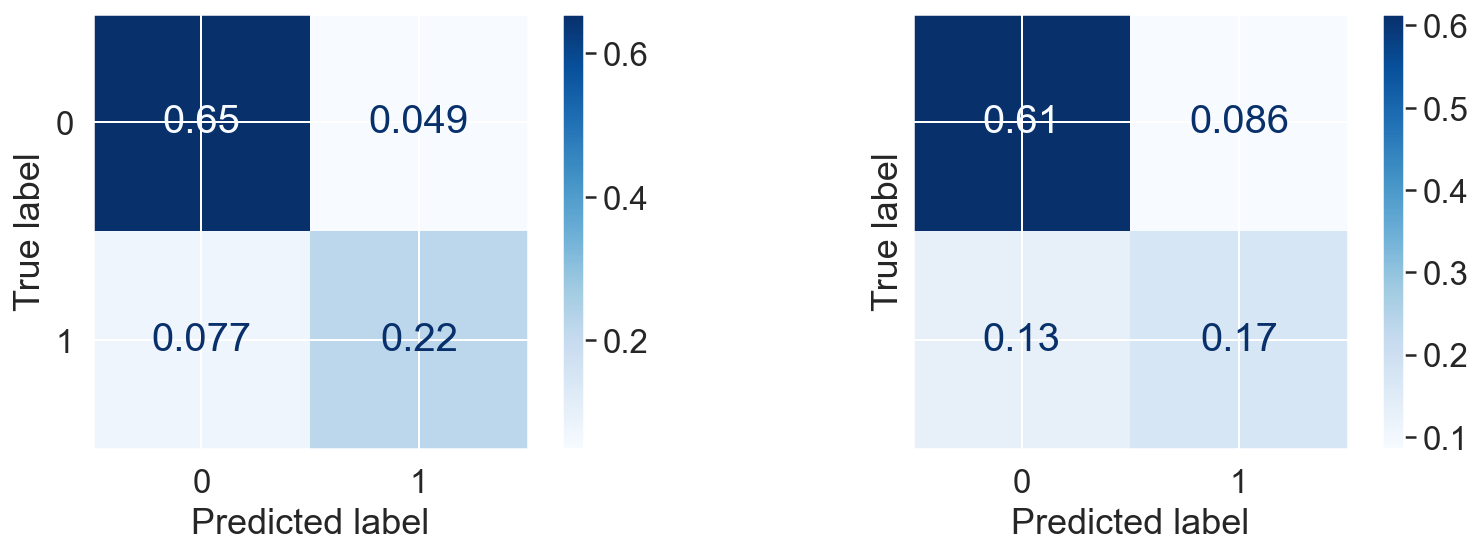

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(gs_rf, X_train, y_train, cmap= 'Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(gs_rf, X_test, y_test, cmap= 'Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show();


### 5.1.8. Classification Report

In [47]:
#calculation of the predictors
yhat_model_train = gs_rf.predict(X_train)
yhat_model_test = gs_rf.predict(X_test)


In [48]:
#calculating the probabilities
probabilities_train = gs_rf.predict_proba(X_train)
probabilities_test = gs_rf.predict_proba(X_test)


In [49]:
#printing the classification report
print(classification_report(y_train, yhat_model_train))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       100
           1       0.82      0.74      0.78        42

    accuracy                           0.87       142
   macro avg       0.86      0.83      0.84       142
weighted avg       0.87      0.87      0.87       142



### 5.1.9. Plot the ROC curve on the training and test set

In [50]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [51]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

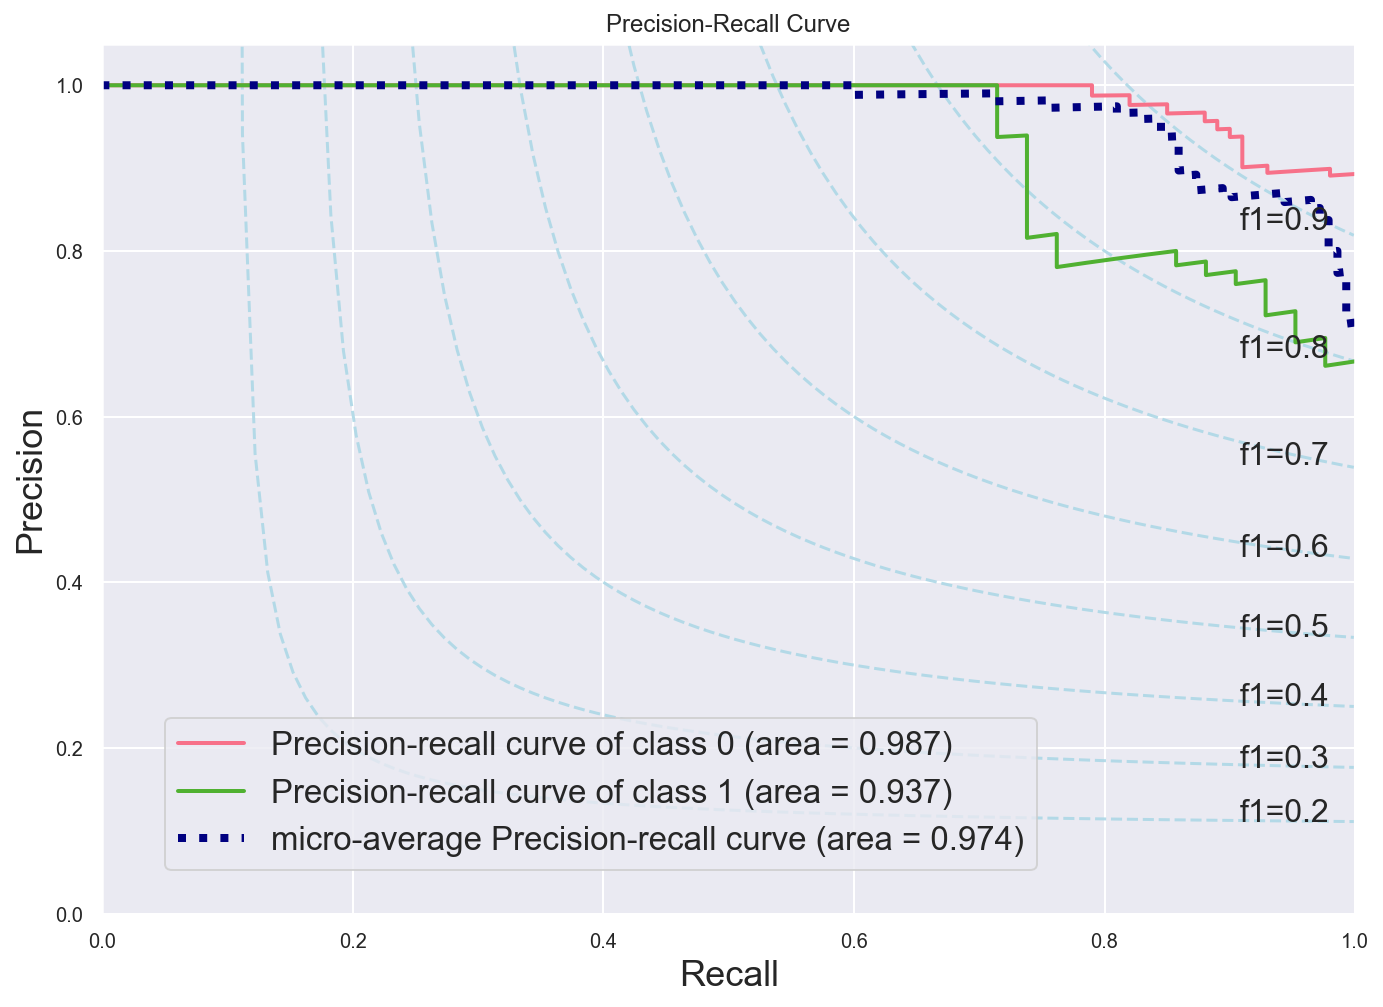

In [52]:
fig, ax = plot_f1_lines(figsize=(10, 8))
skplt.metrics.plot_precision_recall(y_train, probabilities_train, cmap=cmap, ax = ax)
ax.legend(loc=[0.05, 0.05])
plt.show()


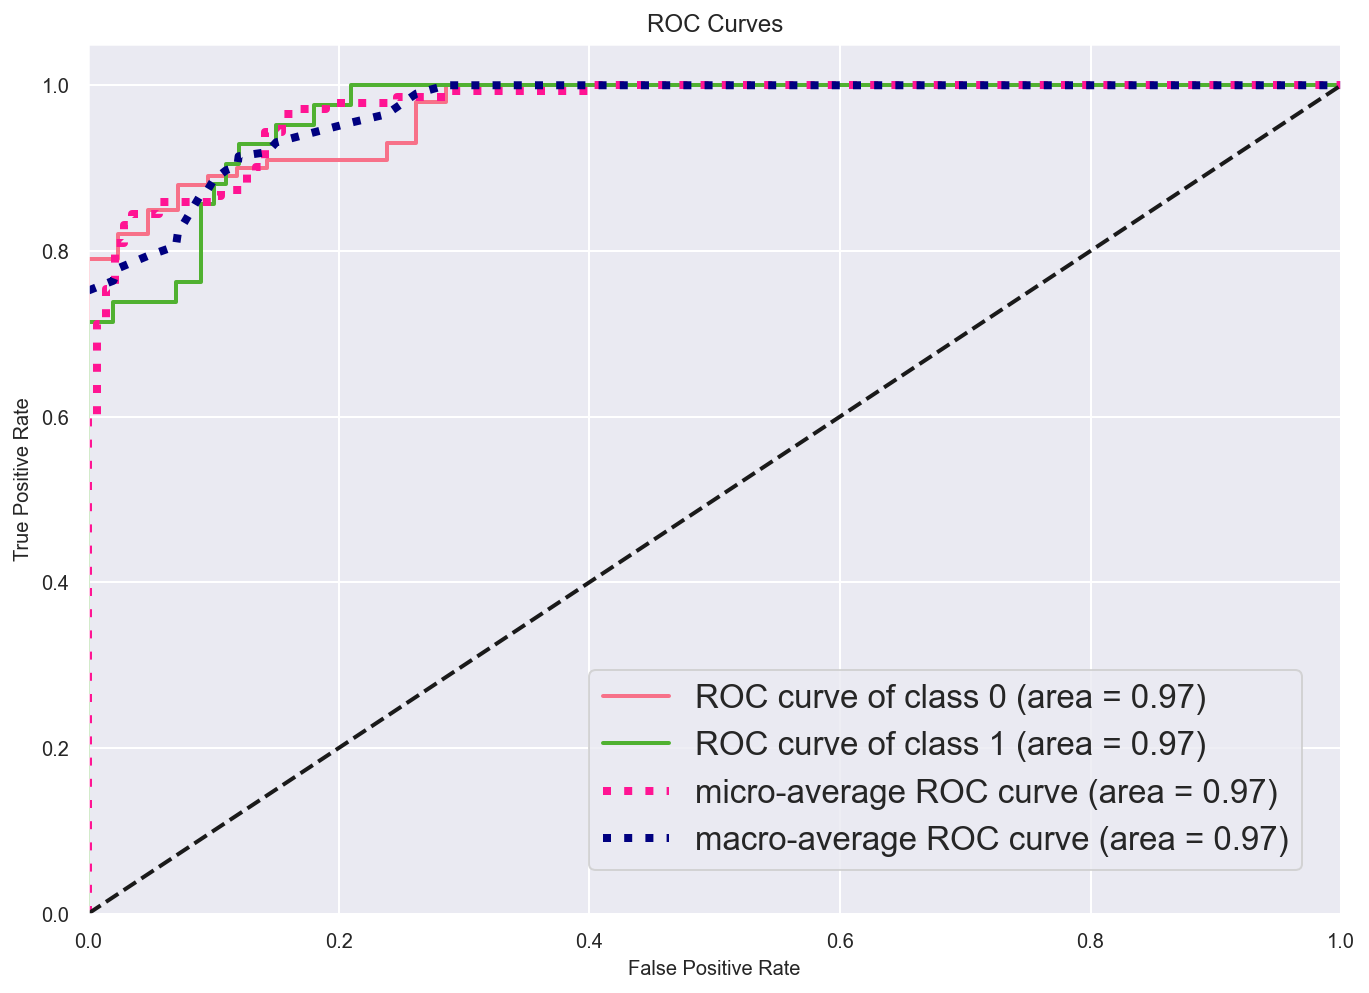

In [53]:
#print the ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc(y_train, probabilities_train, cmap=cmap, ax = ax)
ax.legend(loc=[0.4, 0.05])
plt.show()

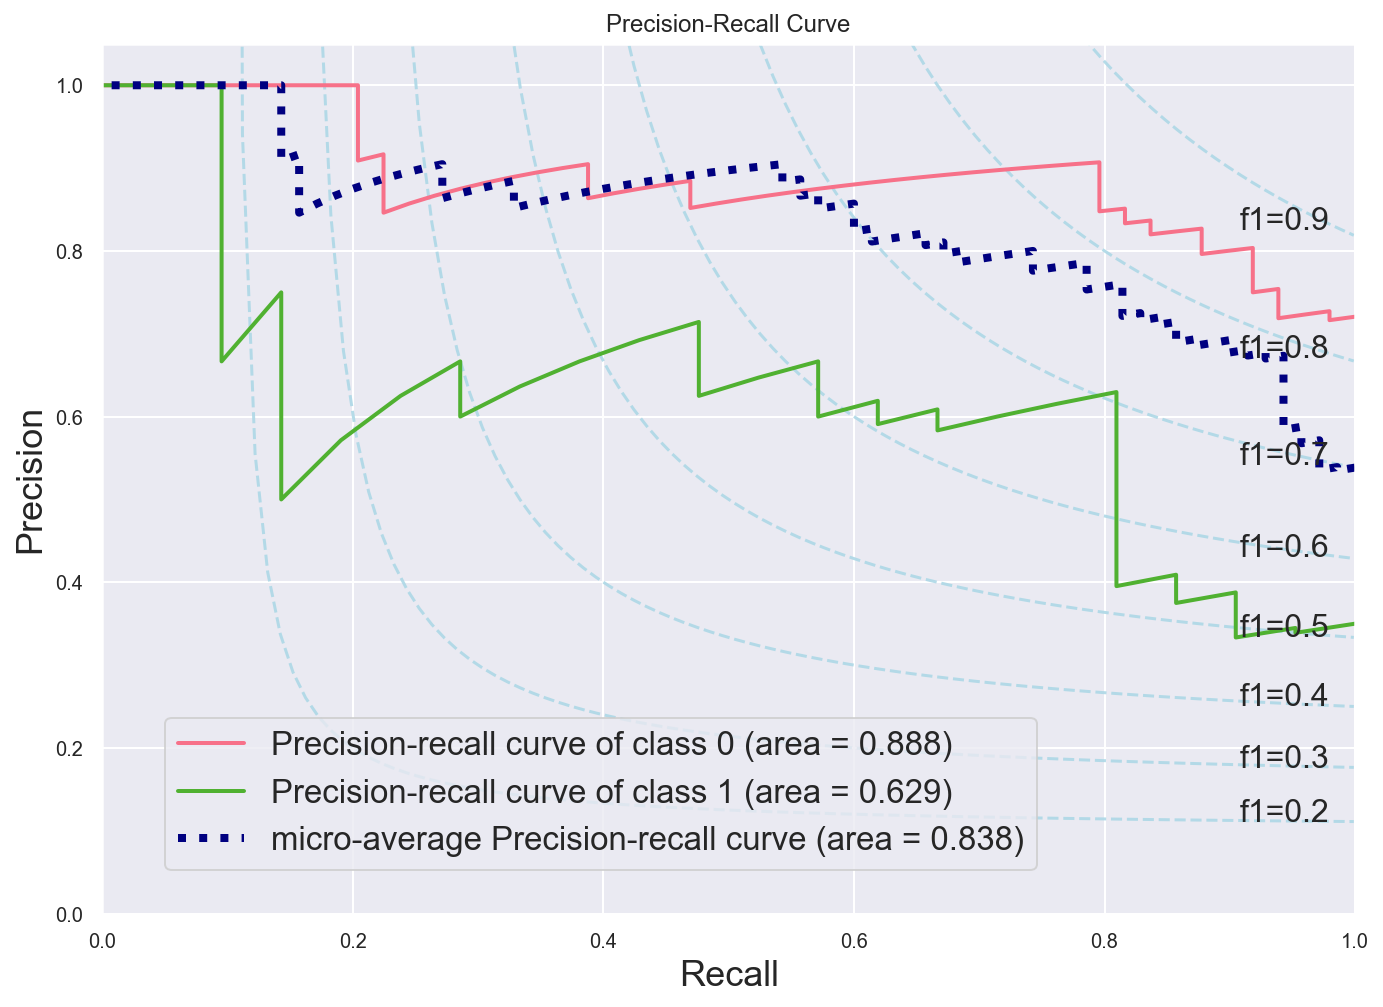

In [54]:
fig, ax = plot_f1_lines(figsize=(10, 8))
skplt.metrics.plot_precision_recall(y_test, probabilities_test, cmap=cmap, ax = ax)
ax.legend(loc=[0.05, 0.05])
plt.show()


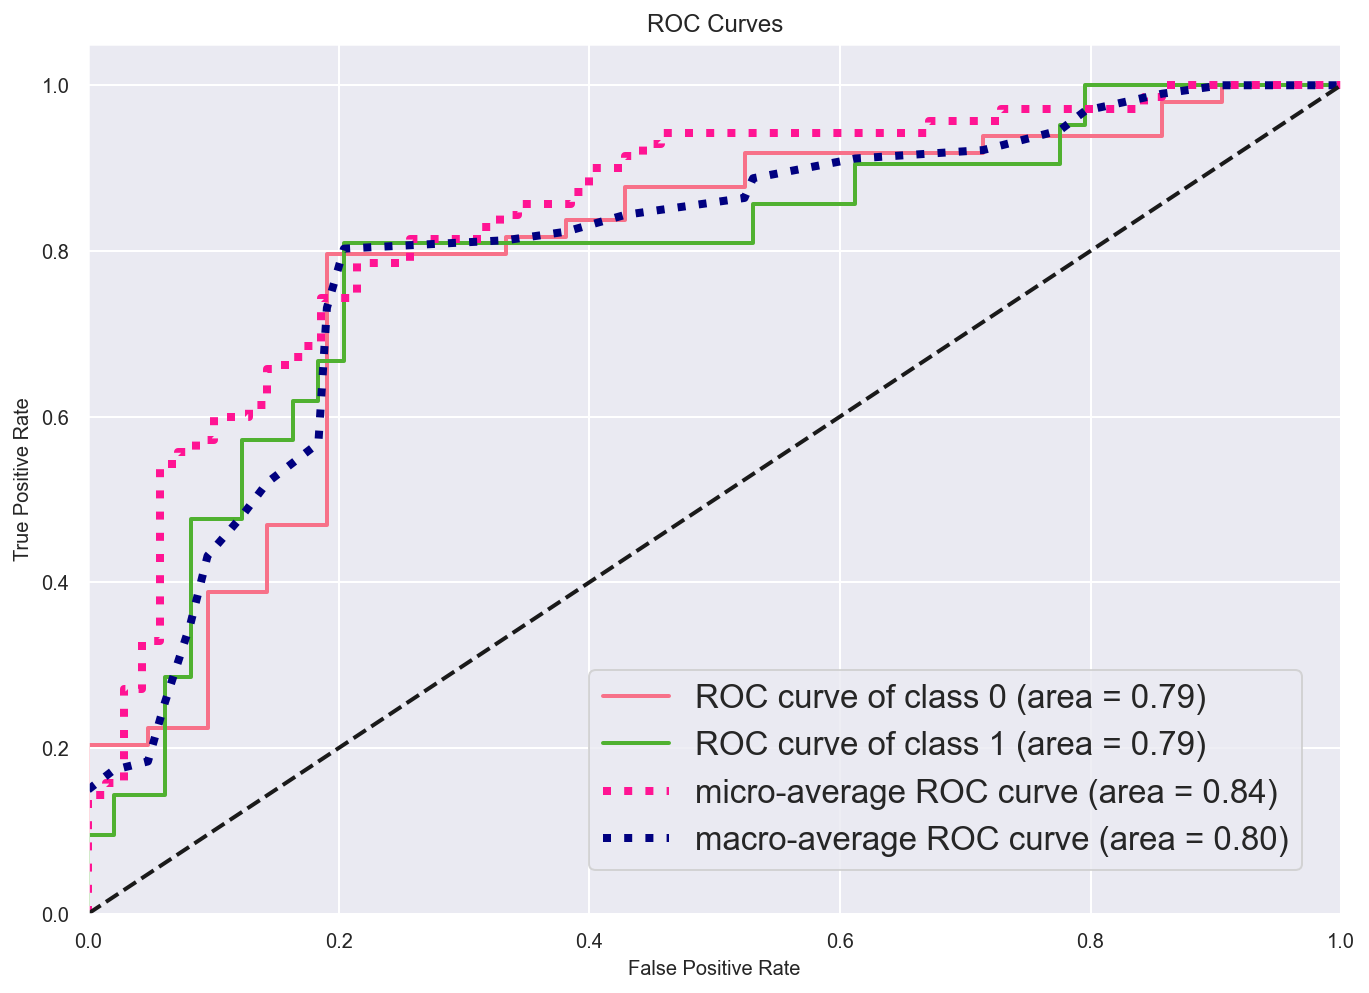

In [55]:
#print the ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc(y_test, probabilities_test, cmap=cmap, ax = ax)
ax.legend(loc=[0.4, 0.05])
plt.show()

## 5.2 How many replies a quoted tweeted will have

### 5.2.1 Setting the variables

In [56]:
#upload the new csv file
df_eda = pd.read_csv('/Users/anasfmatias/Desktop/DS/Final Capstone/df_eda_3May.csv')
df_eda.head(2)

,Unnamed: 0,id,username,content,verified_status,reply_count,like_count,quote_count,number_followers,source,...,stock,buy,short,market,gme,trade,share,reddit,order,amc
0,2020-09-01 00:02:26+00:00,1.300585e+18,jefbiz,Sell yo house pass GO and spend $300 at Game Stop. #manchild https://t.co/RthevPBgl5,False,0.0,1.0,0.0,113.0,Twitter for iPhone,...,0,0,0,0,0,0,0,0,0,0
1,2020-09-01 00:03:27+00:00,1.300585e+18,BaldOldHead,@adinross He did say he has a gamestop plug or something,False,0.0,0.0,0.0,39.0,Twitter for iPhone,...,0,0,0,0,0,0,0,0,0,0


In [57]:
#transform datetime column in a datetime object
df_eda['Unnamed: 0'] = pd.to_datetime(df_eda['Unnamed: 0'])

#transform date column in index column
df_eda.set_index('Unnamed: 0', inplace = True, drop = True)

# #reset index column name
df_eda.index.name = None
df_eda.head(2)

,id,username,content,verified_status,reply_count,like_count,quote_count,number_followers,source,emojis,...,stock,buy,short,market,gme,trade,share,reddit,order,amc
2020-09-01 00:02:26+00:00,1.300585e+18,jefbiz,Sell yo house pass GO and spend $300 at Game Stop. #manchild https://t.co/RthevPBgl5,False,0.0,1.0,0.0,113.0,Twitter for iPhone,NaN,...,0,0,0,0,0,0,0,0,0,0
2020-09-01 00:03:27+00:00,1.300585e+18,BaldOldHead,@adinross He did say he has a gamestop plug or something,False,0.0,0.0,0.0,39.0,Twitter for iPhone,NaN,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#select the results where the tweets where quoted
df_quote = df_eda[df_eda['quote_count'] != 0]


#### Setting Target Predictors

In [59]:
#target
y = df_quote[['reply_count']]

#predictors
X = df_quote[['like_count', 'quote_count', 'number_followers', 'text_len', 'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos',
             'stock', 'buy', 'short', 'market', 'gme', 'trade', 'share', 'reddit', 'order', 'amc']]

#### Train Test Split

In [60]:
#split the data into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)


#### Standardization

In [61]:
#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### 5.2.2. Linear Regression (Fit and Score Model)

#### Linear Regression

In [62]:
#train the model under linear regression, get cross validated scores
model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, X_train, y_train, cv = 5)
model_lr.fit(X_train, y_train)
joblib.dump(model_lr, 'model_lr_rc.jlib')

['model_lr_rc.jlib']

In [63]:
#model_lr = joblib.load('model_lr_rc.jlib')
scores_lr = cross_val_score(model_lr, X_train, y_train, cv = 5)

#summarize results
print("Mean cross-validated training score:", scores_lr.mean())
print('Accuracy of Linear Regression on Training Set: {:.2f}'.format(model_lr.score(X_train, y_train)))
print('Accuracy of Linear Regression on Test Set: {:.2f}'.format(model_lr.score(X_test, y_test)))

Mean cross-validated training score: 0.37709266200525116
Accuracy of Linear Regression on Training Set: 0.50
Accuracy of Linear Regression on Test Set: 0.17


In [64]:
# Create a dataframe to look at the coefficients
coef_df_lr = pd.DataFrame({'feature': X.columns,
                        'coef': model_lr.coef_[0],
                        'abs_coef': np.abs(model_lr.coef_[0])})
# Sort by absolute value of coefficient (magnitude)
coef_df_lr = coef_df_lr.sort_values(by='abs_coef', ascending=False)
coef_df_lr

,feature,coef,abs_coef
6,vader_neu,-532.257101,532.257101
7,vader_pos,-422.781536,422.781536
5,vader_neg,-389.393895,389.393895
1,quote_count,71.297641,71.297641
0,like_count,23.286816,23.286816
2,number_followers,5.397001,5.397001
11,market,1.953853,1.953853
4,vader_compound,1.688414,1.688414
16,order,1.621207,1.621207
15,reddit,-1.581013,1.581013


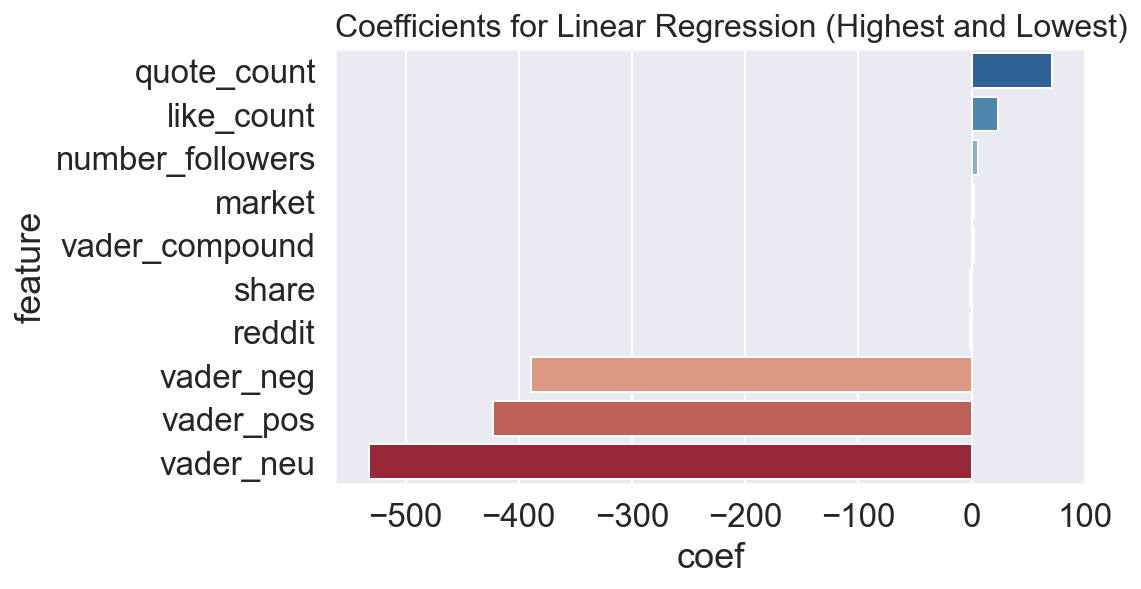

In [65]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_lr.sort_values(by='coef', ascending=False).head(5),
                      coef_df_lr.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for Linear Regression (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Linear Regression using Ridge Penalty

In [66]:
#train the model under Ridge Penalty
model_rc = RidgeCV(alphas=np.logspace(-2, 20, 10), cv=5)
model_rc.fit(X_train, y_train)
model_r_best = Ridge(alpha=model_rc.alpha_)
model_r_best.fit(X_train, y_train)
joblib.dump(model_r_best, 'model_r_best.jlib')

['model_r_best.jlib']

In [67]:
#model_r_best = joblib.load('model_r_best.jlib')
cross_val = cross_val_score(model_r_best, X_train, y_train, cv=5).mean()

#summarize results
print('Best Alpha(Ridge): {:.2f}'.format(model_rc.alpha_))
print('Cross Validation Score(Ridge): {:.2f}'.format(cross_val))
print('Accuracy of Logistic Regression Classifier on Training Set(Ridge): {:.2f}'.format(model_r_best.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on Test Set(Ridge): {:.2f}'.format( model_r_best.score(X_test, y_test)))


Best Alpha(Ridge): 774.26
Cross Validation Score(Ridge): 0.39
Accuracy of Logistic Regression Classifier on Training Set(Ridge): 0.50
Accuracy of Logistic Regression Classifier on Test Set(Ridge): 0.19


In [68]:
# Create a dataframe to look at the coefficients
coef_df_r = pd.DataFrame({'feature': X.columns,
                        'coef': model_r_best.coef_[0],
                        'abs_coef': np.abs(model_r_best.coef_[0])})
# Sort by absolute value of coefficient (magnitude)
coef_df_r = coef_df_r.sort_values(by='abs_coef', ascending=False)
coef_df_r

,feature,coef,abs_coef
1,quote_count,69.886418,69.886418
0,like_count,23.275414,23.275414
2,number_followers,5.358628,5.358628
11,market,1.958305,1.958305
16,order,1.594774,1.594774
4,vader_compound,1.564168,1.564168
15,reddit,-1.523769,1.523769
14,share,-1.394091,1.394091
8,stock,-1.269352,1.269352
3,text_len,1.206367,1.206367


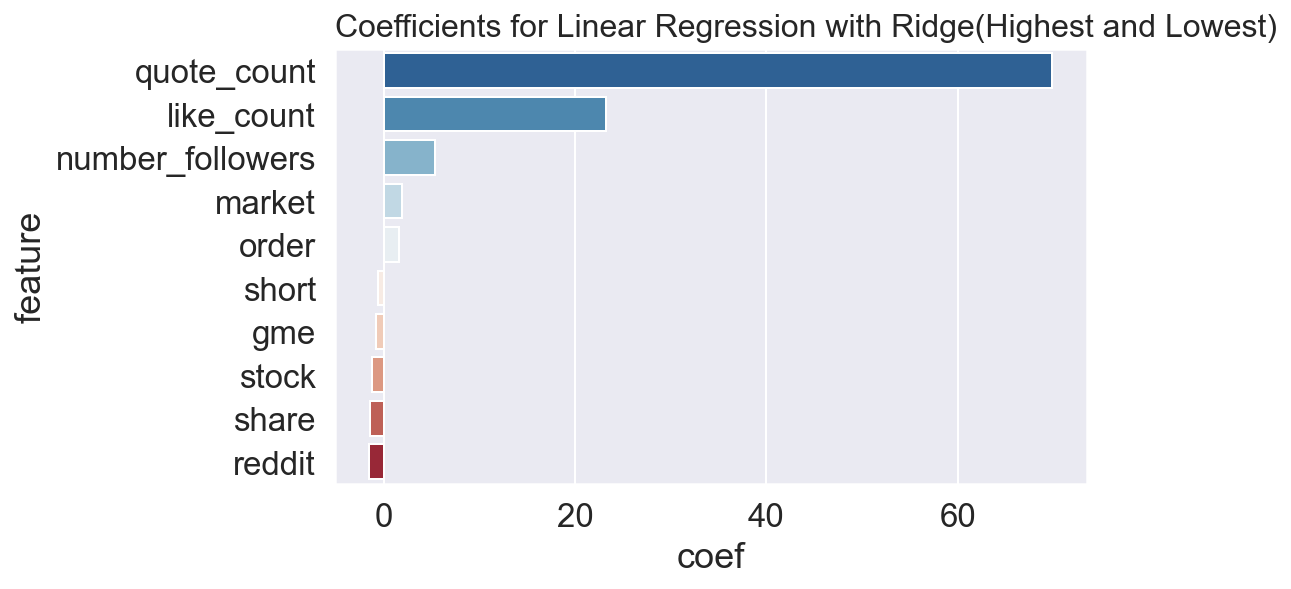

In [69]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_r.sort_values(by='coef', ascending=False).head(5),
                      coef_df_r.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for Linear Regression with Ridge(Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Linear Regression using Lasso Penalty

In [70]:
#train the model under Lasso Penalty
model_l = LassoCV(alphas=np.logspace(-3, 6, 100), cv=10, max_iter=20000)
model_l.fit(X_train, y_train['reply_count'])
model_l_best = Lasso(alpha=model_l.alpha_)
model_l_best.fit(X_train, y_train['reply_count'])
joblib.dump(model_l_best, 'model_l_best.jlib')

['model_l_best.jlib']

In [71]:
#model_l_best = joblib.load('model_l_best.jlib')
cross_val = cross_val_score(model_l_best, X_train, y_train, cv=5).mean()

#summarize results
print('Best Alpha(Lasso): {:.2f}'.format(model_l.alpha_))
print('Cross Validation Score(Lasso): {:.2f}'.format(cross_val))
print('Accuracy of Logistic Regression Classifier on Training Set(Lasso): {:.2f}'.format(model_l_best.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on Test Set(Lasso): {:.2f}'.format(model_l_best.score(X_test, y_test)))


Best Alpha(Lasso): 0.43
Cross Validation Score(Lasso): 0.38
Accuracy of Logistic Regression Classifier on Training Set(Lasso): 0.50
Accuracy of Logistic Regression Classifier on Test Set(Lasso): 0.18


In [72]:
# Create a dataframe to look at the coefficients
coef_df_l = pd.DataFrame({'feature': X.columns,
                        'coef': model_l_best.coef_,
                        'abs_coef': np.abs(model_l_best.coef_)})
# Sort by absolute value of coefficient (magnitude)
coef_df_l = coef_df_l.sort_values(by='abs_coef', ascending=False)
coef_df_l

,feature,coef,abs_coef
1,quote_count,71.000091,71.000091
0,like_count,22.972833,22.972833
2,number_followers,4.934254,4.934254
11,market,1.493863,1.493863
16,order,1.309005,1.309005
15,reddit,-1.163893,1.163893
4,vader_compound,1.100387,1.100387
14,share,-0.938804,0.938804
8,stock,-0.754373,0.754373
3,text_len,0.663775,0.663775


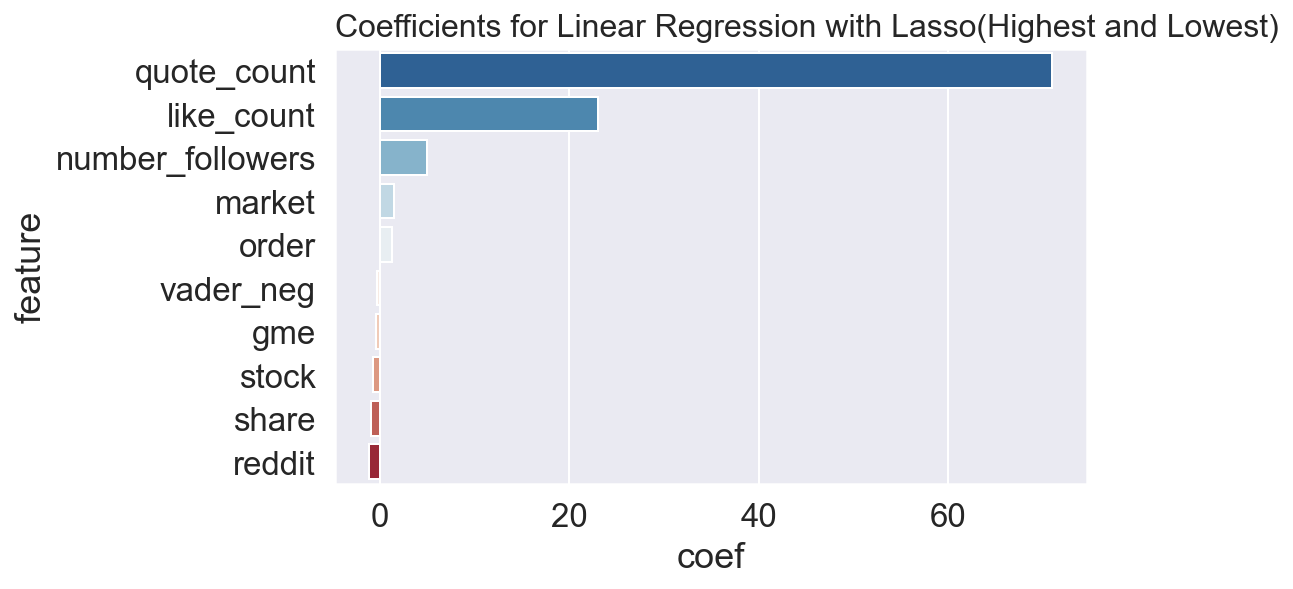

In [73]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_l.sort_values(by='coef', ascending=False).head(5),
                      coef_df_l.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for Linear Regression with Lasso(Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

#### Linear Regression using ElasticNet Penalty

In [74]:
#train the model under ElasticNet regularization
model_elast = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5, max_iter = 2000000)

model_elast.fit(X_train, y_train['reply_count'])
model_elast_best = ElasticNet(alpha=model_elast.alpha_)
model_elast_best.fit(X_train, y_train['reply_count'])
joblib.dump(model_elast_best, 'model_l_best.jlib')

['model_l_best.jlib']

In [75]:
#model_elast_best = joblib.load('model_elast_best.jlib')
cross_val = cross_val_score(model_elast_best, X_train, y_train, cv=5).mean()

#summarize results
print('Best Alpha(ElasticNet): {:.2f}'.format(model_elast.alpha_))
print('Cross Validation Score(ElasticNet): {:.2f}'.format(cross_val))
print('Accuracy of ElasticNet on Training Set(ElasticNet): {:.2f}'.format(model_elast_best.score(X_train, y_train['reply_count'])))
print('Accuracy of ElasticNet on Test Set(ElasticNet): {:.2f}'.format(model_elast_best.score(X_test, y_test['reply_count'])))


Best Alpha(ElasticNet): 0.36
Cross Validation Score(ElasticNet): 0.43
Accuracy of ElasticNet on Training Set(ElasticNet): 0.49
Accuracy of ElasticNet on Test Set(ElasticNet): 0.26


In [76]:
# Create a dataframe to look at the coefficients
coef_df_el = pd.DataFrame({'feature': X.columns,
                        'coef': model_elast_best.coef_,
                        'abs_coef': np.abs(model_elast_best.coef_)})

# Sort by absolute value of coefficient (magnitude)
coef_df_el = coef_df_el.sort_values(by='abs_coef', ascending=False)
coef_df_el

,feature,coef,abs_coef
1,quote_count,60.493479,60.493479
0,like_count,22.604976,22.604976
2,number_followers,4.849618,4.849618
11,market,1.659603,1.659603
16,order,1.273224,1.273224
15,reddit,-1.050308,1.050308
14,share,-1.000578,1.000578
4,vader_compound,0.957104,0.957104
3,text_len,0.938779,0.938779
8,stock,-0.674243,0.674243


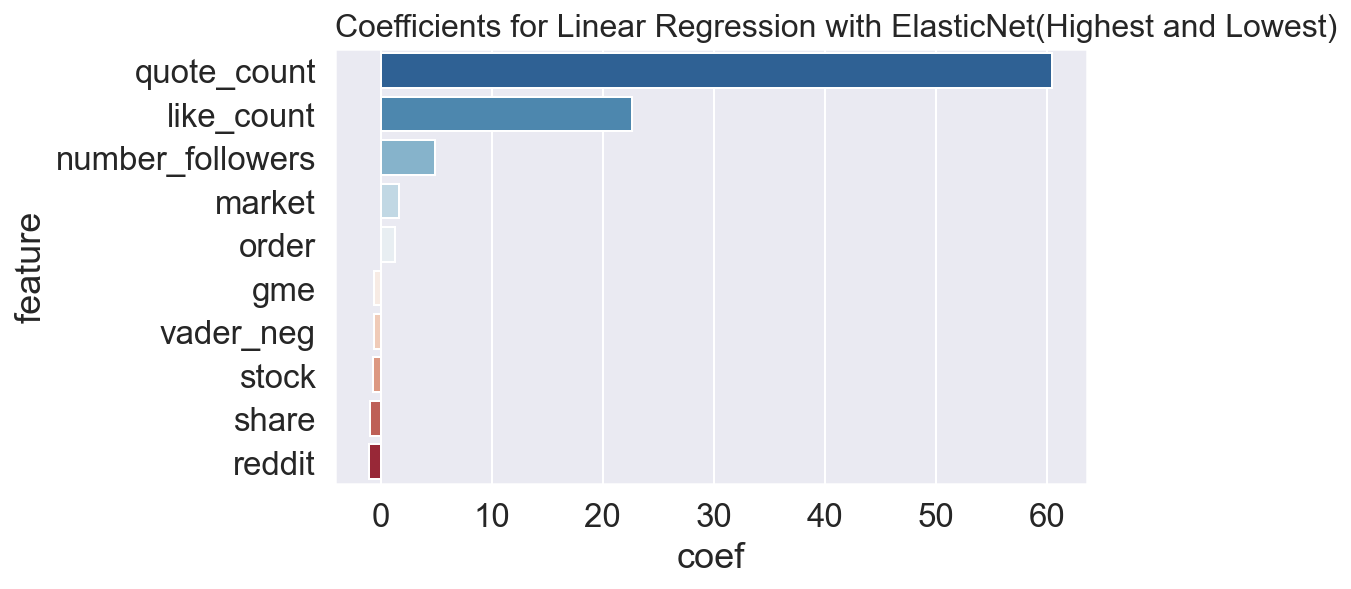

In [77]:
# Plot the coefficient table
sort_coef = pd.concat([coef_df_el.sort_values(by='coef', ascending=False).head(5),
                      coef_df_el.sort_values(by='coef', ascending=False).tail(5)])
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for Linear Regression with ElasticNet(Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

### 5.2.3. Random Forest (Fit and Score Model)
Random forest is an emsemble machine learning algorithm, that consist on an ensemble of decision trees. Randomness is used 

In [78]:
model_rf_r = RandomForestRegressor(
                            max_depth = 5,
                           n_estimators=100,
                            max_features = 'sqrt',
                           random_state=1)
model_rf_r.fit(X_train, y_train['reply_count'])
joblib.dump(model_rf_r, 'model_rf_r.jlib')

['model_rf_r.jlib']

In [79]:
#model_rf_r = joblib.load('model_rf_r.jlib')
cross_val = cross_val_score(model_rf_r, X_train, y_train['reply_count'], cv=5).mean()

#summarize results
print('Cross Validation Score(Random Forest): {:.2f}'.format(cross_val))
print('Accuracy of Training Set(Random Forest): {:.2f}'.format(model_rf_r.score(X_train, y_train['reply_count'])))
print('Accuracy of Test Set(Random Forest): {:.2f}'.format(model_rf_r.score(X_test, y_test['reply_count'])))

Cross Validation Score(Random Forest): 0.45
Accuracy of Training Set(Random Forest): 0.70
Accuracy of Test Set(Random Forest): 0.53


In [80]:
# Create a dataframe to look at the coefficients
coef_rf_r = pd.DataFrame({'feature': X.columns,
                        'coef': model_rf_r.feature_importances_,
                        'abs_coef': np.abs(model_rf_r.feature_importances_)})

# Sort by absolute value of coefficient (magnitude)
coef_rf_r = coef_rf_r.sort_values(by='abs_coef', ascending=False)
coef_rf_r

,feature,coef,abs_coef
1,quote_count,0.502493,0.502493
0,like_count,0.247952,0.247952
2,number_followers,0.084860,0.084860
3,text_len,0.029297,0.029297
6,vader_neu,0.026663,0.026663
4,vader_compound,0.026186,0.026186
11,market,0.024132,0.024132
7,vader_pos,0.017605,0.017605
5,vader_neg,0.016725,0.016725
13,trade,0.004715,0.004715


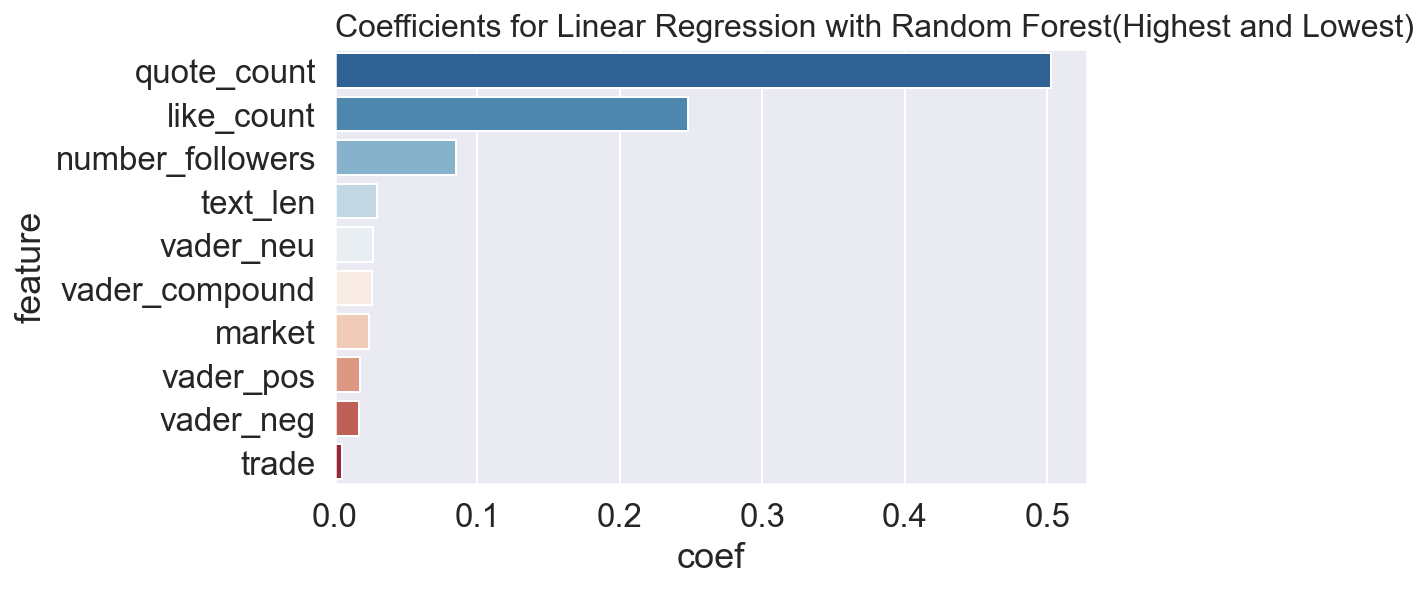

In [81]:
# Plot the coefficient table
#sort_coef = pd.concat([coef_rf_r.sort_values(by='coef', ascending=False).head(5),
                      #coef_rf_r.sort_values(by='coef', ascending=False).tail(5)])
sort_coef = coef_rf_r.sort_values(by='coef', ascending=False).head(10)
sns.barplot(y = sort_coef.feature, x = sort_coef.coef, palette = "RdBu_r")
plt.title("Coefficients for Linear Regression with Random Forest(Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

### 5.2.4. KNN Regressor (Fit and Score Model)

In [82]:
knn_regressor = KNeighborsRegressor(n_neighbors=8)
knn_regressor.fit(X_train, y_train)
joblib.dump(knn_regressor, 'knn_regressor.jlib')

['knn_regressor.jlib']

In [83]:
#knn_regressor = joblib.load('knn_regressor.jlib')
cross_val = cross_val_score(knn_regressor, X_train, y_train, cv=5).mean()

#summarize results
print('Cross Validation Score(Random Forest): {:.2f}'.format(cross_val))
print('Accuracy of Training Set(Random Forest): {:.2f}'.format(knn_regressor.score(X_train, y_train)))
print('Accuracy of Test Set(Random Forest): {:.2f}'.format(knn_regressor.score(X_test, y_test)))

Cross Validation Score(Random Forest): 0.44
Accuracy of Training Set(Random Forest): 0.54
Accuracy of Test Set(Random Forest): 0.44


### 5.2.5. Bagging Regressor(Fit and Score Model)

In [84]:
base_estimator = DecisionTreeRegressor(max_depth=5, max_features=0.8)
bag_reg_model = BaggingRegressor(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1, n_jobs = -1)
bag_reg_model.fit(X_train, y_train)
joblib.dump(bag_reg_model, 'bag_reg_model.jlib')

/Users/anasfmatias/opt/anaconda3/envs/fproject/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


['bag_reg_model.jlib']

In [85]:
#bag_reg_model = joblib.load('bag_reg_model.jlib')
cross_val = cross_val_score(bag_reg_model, X_train, y_train, cv=5).mean()

#summarize results
print('Cross Validation Score(Bagging Regressor): {:.2f}'.format(cross_val))
print('Accuracy of Training Set(Bagging Regressor): {:.2f}'.format(bag_reg_model.score(X_train, y_train)))
print('Accuracy of Test Set(Bagging Regressor): {:.2f}'.format(bag_reg_model.score(X_test, y_test)))

/Users/anasfmatias/opt/anaconda3/envs/fproject/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/anasfmatias/opt/anaconda3/envs/fproject/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/anasfmatias/opt/anaconda3/envs/fproject/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/anasfmatias/opt/anaconda3/envs/fproject/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarnin

Cross Validation Score(Bagging Regressor): 0.49
Accuracy of Training Set(Bagging Regressor): 0.81
Accuracy of Test Set(Bagging Regressor): 0.48


In [86]:
#select all the coefficients
n_estimators=100
coef_BR = [sum(val)/(n_estimators-1) for val in zip(*[bag_reg_model.estimators_[i].feature_importances_ for i in range(n_estimators-1)])]

# Create a DataFrame to look at the coefficients
coef_BR = pd.DataFrame({'feature': X.columns,
                        'coef': coef_BR,
                        'abs_coef': np.abs(coef_BR)})

# Sort by absolute value of coefficient (magnitude)
coef_BR = coef_BR.sort_values(by='abs_coef', ascending=False)
coef_BR

,feature,coef,abs_coef
1,quote_count,0.629892,0.629892
0,like_count,0.145565,0.145565
2,number_followers,0.081057,0.081057
11,market,0.053093,0.053093
3,text_len,0.014838,0.014838
4,vader_compound,0.013148,0.013148
7,vader_pos,0.012391,0.012391
16,order,0.011646,0.011646
6,vader_neu,0.010035,0.010035
5,vader_neg,0.008762,0.008762


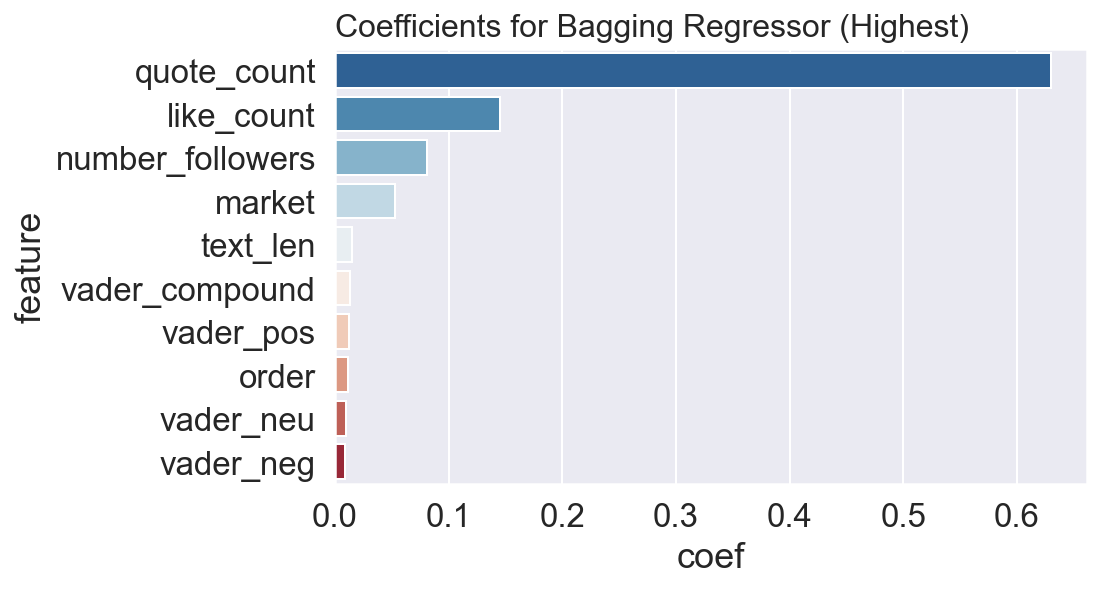

In [87]:
# Plot the coefficient table
coef_BR = coef_BR.sort_values(by='coef', ascending=False).head(10)
sns.barplot(y = coef_BR.feature, x = coef_BR.coef, palette = "RdBu_r")
plt.title("Coefficients for Bagging Regressor (Highest)", loc = 'left', fontsize = 16)
plt.show()

#### Predictors

In [88]:
predic_fixed_feat_train = bag_reg_model.predict(X_train)
predic_fixed_feat_test = bag_reg_model.predict(X_test)


#### Residuals

In [89]:
res_fixed_feat_train = y_train['reply_count'] - predic_fixed_feat_train
res_fixed_feat_test = y_test['reply_count'] - predic_fixed_feat_test 


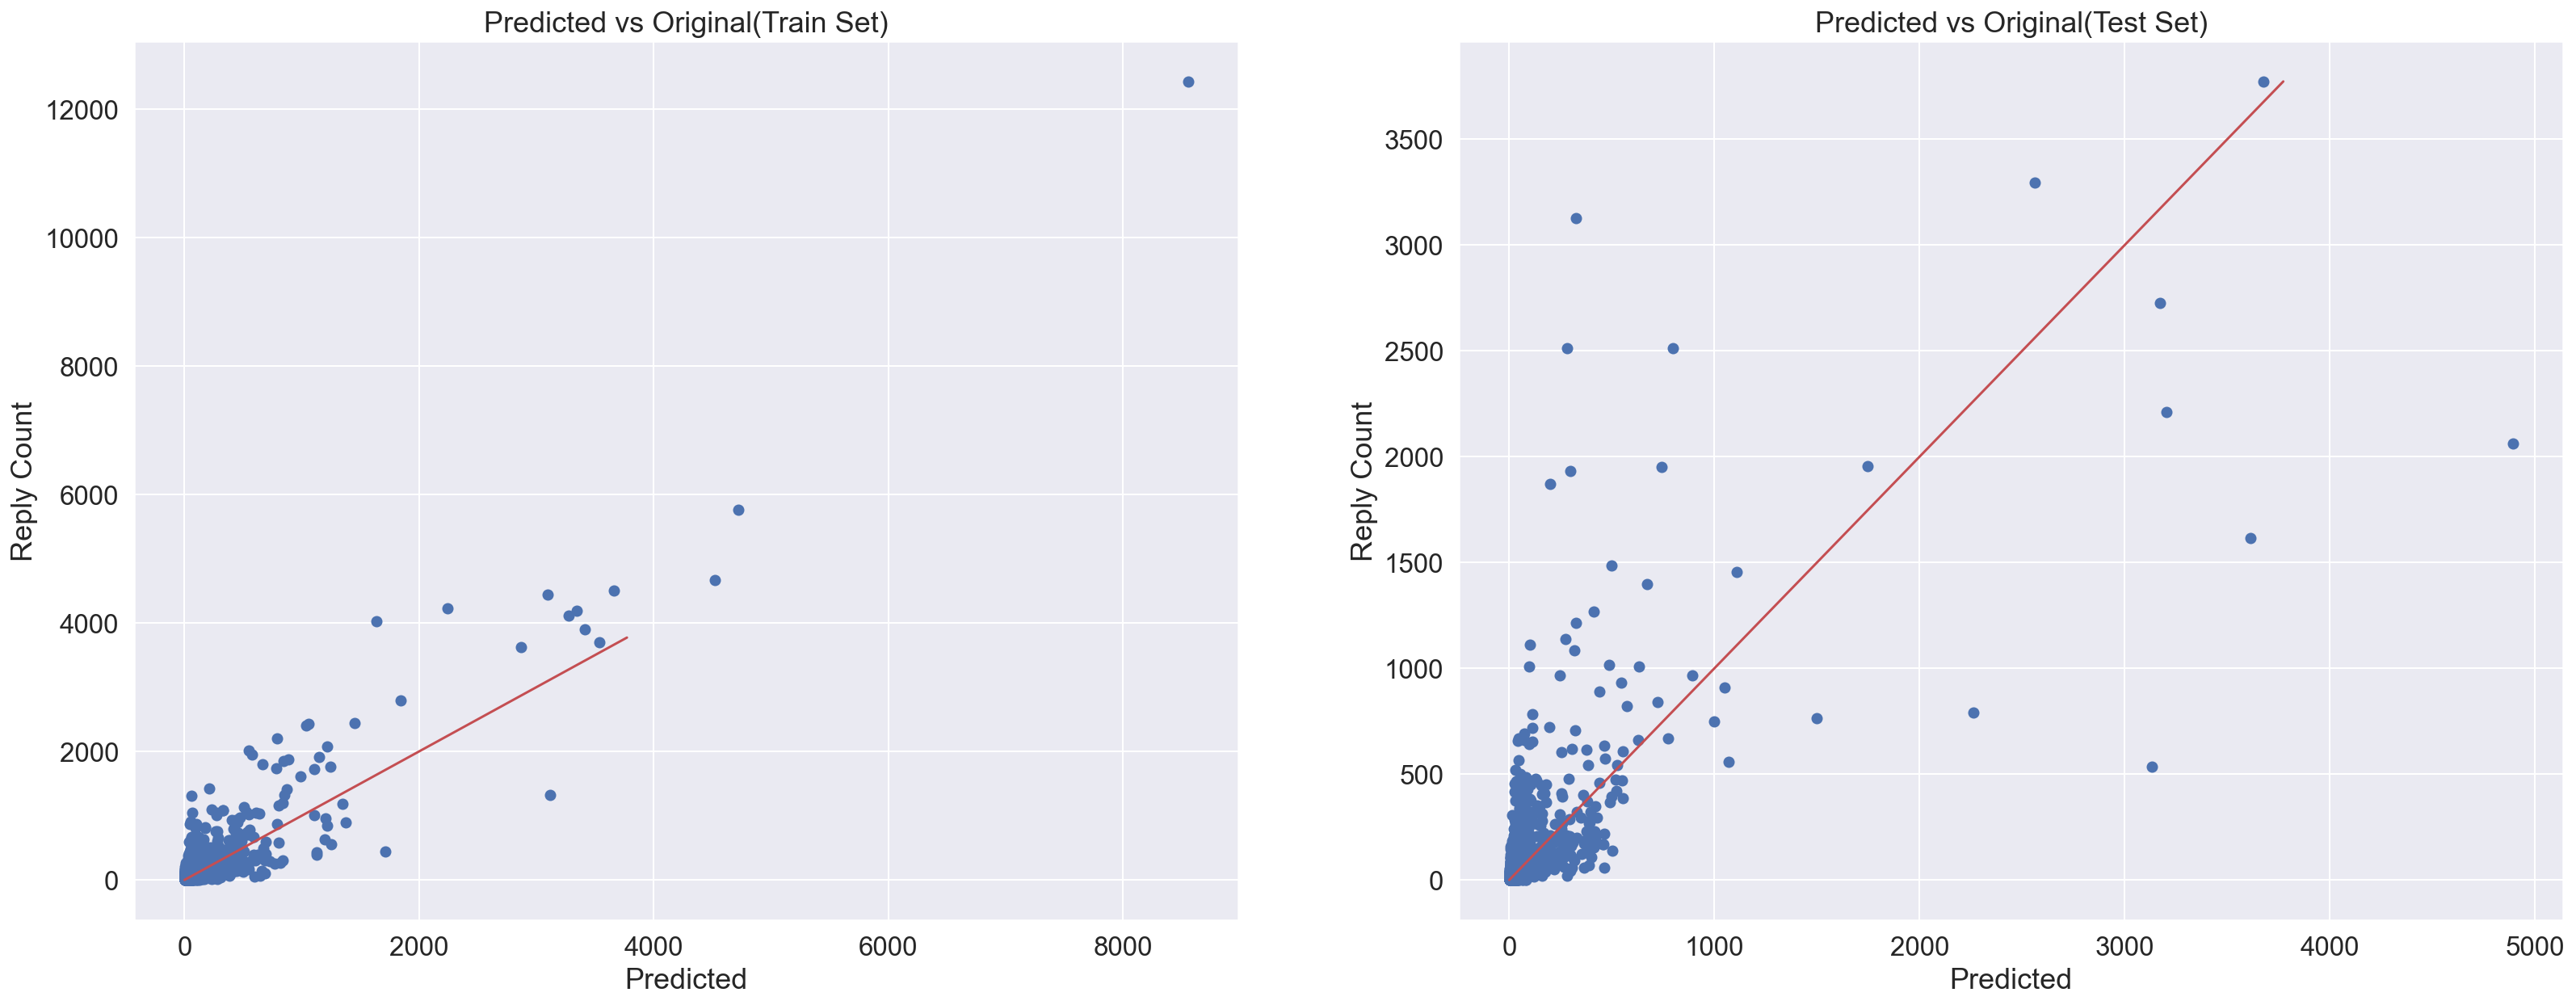

In [90]:
fig, ax = plt.subplots(ncols = 2, figsize=(24,10))
ax[0].scatter(predic_fixed_feat_train, y_train)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
ax[0].set_title('Predicted vs Original(Train Set)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Reply Count')
ax[1].scatter(predic_fixed_feat_test, y_test)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
ax[1].set_title('Predicted vs Original(Test Set)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Reply Count')
plt.show()
